# Notebook for reconstructing from untreated data

First, we extract the particle and make the star files.

In [ ]:
import pandas as pd
import mrcfile
import numpy as np
import os
from pathlib import Path
import glob
import starfile
import sys
import random

# Set up the command line arguments
sys.argv = [
    'export_relion_constrained.py',
    'xe30kv/results_all_steps_noB_3/final_results/',
    'xe30kv/results_refine_tm_60S_noB/',
    'xe30kv/extracted_60S_constrained_noB_2_-1/',
    '--box-size', '512',
    '--csv-suffix-60s', '_refined_results.csv',
    '--csv-suffix-40s', '_constrained_results_above_threshold.csv'
]

def wrap_angle(angle):
    """Wrap angle from 0-360 to -180 to 180 degrees"""
    return (angle + 180) % 360 - 180

def create_star_file(df, output_dir, output_star_path, box_size) -> None:
    """
    Create a particles.star file from the particle data.
    
    Args:
        df (pandas.DataFrame): DataFrame containing particle data
        output_dir (str): Directory containing the particle stacks
        output_star_path (str): Path to save the star file
        box_size (int): Size of the box used for particle extraction
    """
    # Create a new DataFrame for particles
    particle_df = pd.DataFrame()
    
    # Group by micrograph to get particle indices
    for micrograph_path, particles in df.groupby('micrograph_path'):
        mrcs_name = f"{Path(micrograph_path).stem}.mrcs"
        mrcs_rel_path = os.path.join(output_dir, mrcs_name)
        
        # Add each particle to the particle DataFrame
        for _, particle in particles.iterrows():
            particle_data = {
                'rlnCoordinateX': particle['pos_x'],
                'rlnCoordinateY': particle['pos_y'],
                'rlnImageName': f"{particle['stack_order']:06d}@{mrcs_rel_path}",
                'rlnMicrographName': micrograph_path,  # Use full path
                'rlnOpticsGroup': 1,
                'rlnDefocusU': particle['defocus_u'] + particle['refined_relative_defocus'],
                'rlnDefocusV': particle['defocus_v'] + particle['refined_relative_defocus'],
                'rlnDefocusAngle': particle['astigmatism_angle'],
                'rlnAngleRot': wrap_angle(particle['refined_phi']),
                'rlnAngleTilt': particle['refined_theta'],
                'rlnAnglePsi': wrap_angle(particle['refined_psi']),
                'rlnRandomSubset': random.randint(1, 2)
            }
            particle_df = pd.concat([particle_df, pd.DataFrame([particle_data])], ignore_index=True)
    
    # Create optics DataFrame
    optics_data = {
        'rlnOpticsGroup': 1,
        'rlnOpticsGroupName': 'OpticsGroup1',
        'rlnMicrographOriginalPixelSize': df['refined_pixel_size'].iloc[0],
        'rlnSphericalAberration': df['spherical_aberration'].iloc[0],
        'rlnVoltage': df['voltage'].iloc[0],
        'rlnAmplitudeContrast': df['amplitude_contrast_ratio'].iloc[0],
        'rlnImagePixelSize': df['refined_pixel_size'].iloc[0],
        'rlnImageSize': box_size
    }
    optics_df = pd.DataFrame([optics_data])
    
    # Write the star file
    starfile.write(
        {'optics': optics_df, 'particles': particle_df},
        output_star_path
    )
    print(f"Created star file: {output_star_path}")

def create_particle_stacks(input_40s_dir, input_60s_dir, output_dir, box_size, sort_column='original_offset_psi', 
                         csv_suffix_40s='_results.csv', csv_suffix_60s='_results.csv') -> None:
    """
    Create particle stacks from CSV files containing particle positions.
    
    Args:
        input_40s_dir (str): Directory containing 40S input CSV files
        input_60s_dir (str): Directory containing 60S input CSV files
        output_dir (str): Directory to save the output stacks
        box_size (int): Size of the square box to crop around each particle
        sort_column (str): Column name to use for sorting particles (default: 'original_offset_psi')
        csv_suffix_40s (str): Suffix pattern to match 40S CSV files (default: '_results.csv')
        csv_suffix_60s (str): Suffix pattern to match 60S CSV files (default: '_results.csv')
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all CSV files in both directories
    csv_pattern_40s = os.path.join(input_40s_dir, f'*{csv_suffix_40s}')
    csv_pattern_60s = os.path.join(input_60s_dir, f'*{csv_suffix_60s}')
    csv_files_40s = glob.glob(csv_pattern_40s)
    csv_files_60s = glob.glob(csv_pattern_60s)
    
    if not csv_files_40s or not csv_files_60s:
        print("No CSV files found in one or both input directories")
        return
    
    print(f"Found {len(csv_files_40s)} 40S CSV files and {len(csv_files_60s)} 60S CSV files to process")
    
    # Process 40S particles first to get their states
    forty_s_particles = {}
    for csv_path in csv_files_40s:
        df = pd.read_csv(csv_path)
        for _, particle in df.iterrows():
            micrograph_name = Path(particle['micrograph_path']).stem
            key = (micrograph_name, particle['particle_index'])
            forty_s_particles[key] = particle[sort_column]
    
    # Initialize DataFrames to store particles for each category
    category_dfs = {
        '60S_only': [],
        '40S_nonrotated': [],
        '40S_rotated': [],
        'rest': []  # Add category for particles that don't fit other categories
    }
    
    # Process 60S particles
    for csv_path in csv_files_60s:
        print(f"\nProcessing CSV file: {csv_path}")
        
        # Read the CSV file
        df = pd.read_csv(csv_path)
        
        # Group particles by micrograph
        micrograph_groups = df.groupby('micrograph_path')
        
        for micrograph_path, particles in micrograph_groups:
            print(f"Processing micrograph: {micrograph_path}")
            
            # Get pixel size from first particle in the group
            pixel_size = particles.iloc[0]['refined_pixel_size']
            
            # Load the micrograph
            with mrcfile.open(micrograph_path) as mrc:
                micrograph = mrc.data
            
            # Initialize lists to store particles and their metadata
            particle_data = []
            particle_categories = []  # Store which category each particle belongs to
            
            # Process each particle
            for _, particle in particles.iterrows():
                # Get particle top-left coordinates
                x_start = int(particle['pos_x'])
                y_start = int(particle['pos_y'])
                
                # Calculate box boundaries
                x_end = min(micrograph.shape[-1], x_start + box_size)
                y_end = min(micrograph.shape[-2], y_start + box_size)
                
                # Skip if the box is empty or invalid
                if x_start >= x_end or y_start >= y_end:
                    print(f"Warning: Invalid box coordinates for particle at ({x_start}, {y_start})")
                    continue
                
                # Extract particle
                particle_img = micrograph[..., y_start:y_end, x_start:x_end]
                
                # Create padded image
                padded_img = np.zeros((box_size, box_size), dtype=micrograph.dtype)
                
                # Calculate the region to copy
                copy_height = min(particle_img.shape[-2], box_size)
                copy_width = min(particle_img.shape[-1], box_size)
                
                # Copy the valid region
                padded_img[:copy_height, :copy_width] = particle_img[..., :copy_height, :copy_width]

                #Normalize to mean 0, std 1
                padded_img = (padded_img - padded_img.mean()) / padded_img.std()

                #padded_img *= -1 may want to flip contrast here.
                
                # Check 40S state and determine category
                micrograph_name = Path(micrograph_path).stem
                key = (micrograph_name, particle['particle_index'])
                
                category = '60S_only'  # Default category
                if key in forty_s_particles:
                    psi_value = forty_s_particles[key]
                    if -2.0 <= psi_value <= 2.0:
                        category = '40S_nonrotated'
                    elif -12.0 <= psi_value <= -4.5:
                        category = '40S_rotated'
                    else:
                        category = 'rest'  # 40S particle exists but psi is outside our ranges
                
                # Store particle data and its category
                particle_data.append({
                    'image': padded_img,
                    'metadata': particle
                })
                particle_categories.append(category)
            
            if not particle_data:
                print(f"Warning: No valid particles found in {micrograph_path}")
                continue
            
            # Create single stack for all particles
            particle_stack = np.stack([p['image'] for p in particle_data])
            
            # Create output filename (just one stack per micrograph)
            micrograph_name = Path(micrograph_path).stem
            output_path = os.path.join(output_dir, f"{micrograph_name}.mrcs")
            
            # Save the stack
            with mrcfile.new(output_path, overwrite=True) as mrc:
                mrc.set_data(particle_stack)
                mrc.voxel_size = pixel_size
            
            # Add particles to their respective category DataFrames with their actual stack positions
            for idx, (particle, category) in enumerate(zip(particle_data, particle_categories)):
                particle_df = pd.DataFrame([particle['metadata']])
                particle_df['stack_order'] = idx + 1  # Position in the actual stack
                category_dfs[category].append(particle_df)
    
    # Create star files for each category at the end
    for category, dfs in category_dfs.items():
        if dfs:
            all_particles_df = pd.concat(dfs, ignore_index=True)
            star_file_path = os.path.join(output_dir, f'particles_{category}.star')
            create_star_file(all_particles_df, output_dir, star_file_path, box_size)

    # Create a star file for all particles combined
    all_particles_combined = []
    for dfs in category_dfs.values():
        if dfs:
            all_particles_combined.extend(dfs)

    if all_particles_combined:
        all_particles_df = pd.concat(all_particles_combined, ignore_index=True)
        star_file_path = os.path.join(output_dir, 'particles_all.star')
        create_star_file(all_particles_df, output_dir, star_file_path, box_size)
        print(f"Created combined star file with all particles: {star_file_path}")

if __name__ == "__main__":
    import argparse
    
    parser = argparse.ArgumentParser(description="Process and sort 40S and 60S particles")
    parser.add_argument("input_40s_dir", help="Directory containing 40S input CSV files")
    parser.add_argument("input_60s_dir", help="Directory containing 60S input CSV files")
    parser.add_argument("output_dir", help="Directory to save the output stacks and star files")
    parser.add_argument("--box-size", type=int, default=256, help="Size of the square box to crop around each particle")
    parser.add_argument("--sort-column", default='original_offset_psi',
                      help="Column name to use for sorting particles (default: original_offset_psi)")
    parser.add_argument("--csv-suffix-40s", default='_results.csv',
                      help="Suffix pattern to match 40S CSV files (default: _results.csv)")
    parser.add_argument("--csv-suffix-60s", default='_results.csv',
                      help="Suffix pattern to match 60S CSV files (default: _results.csv)")
    
    args = parser.parse_args()
    
    create_particle_stacks(args.input_40s_dir, args.input_60s_dir, args.output_dir, 
                         args.box_size, args.sort_column, 
                         args.csv_suffix_40s, args.csv_suffix_60s) 

Found 62 40S CSV files and 70 60S CSV files to process

Processing CSV file: xe30kv/results_refine_tm_60S_noB/xenon_268_000_0.0_DWS_refined_results.csv
Processing micrograph: /data/papers/Leopard-EM_paper_data/xe30kv/all_mgraphs/xenon_268_000_0.0_DWS.mrc

Processing CSV file: xe30kv/results_refine_tm_60S_noB/xenon_225_000_0.0_DWS_refined_results.csv
Processing micrograph: /data/papers/Leopard-EM_paper_data/xe30kv/all_mgraphs/xenon_225_000_0.0_DWS.mrc

Processing CSV file: xe30kv/results_refine_tm_60S_noB/xenon_275_000_0.0_DWS_refined_results.csv
Processing micrograph: /data/papers/Leopard-EM_paper_data/xe30kv/all_mgraphs/xenon_275_000_0.0_DWS.mrc

Processing CSV file: xe30kv/results_refine_tm_60S_noB/xenon_253_000_0.0_DWS_refined_results.csv
Processing micrograph: /data/papers/Leopard-EM_paper_data/xe30kv/all_mgraphs/xenon_253_000_0.0_DWS.mrc

Processing CSV file: xe30kv/results_refine_tm_60S_noB/xenon_276_000_0.0_DWS_refined_results.csv
Processing micrograph: /data/papers/Leopard-EM_p

Next, we will reconstruct these with RELION

In [2]:
!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_60S_only.star --o xe30kv/reconstructions_noB/reconstruct_60S-only_half1.mrc --ctf --subset 1
!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_60S_only.star --o xe30kv/reconstructions_noB/reconstruct_60S-only_half2.mrc --ctf --subset 2
# Next, we'll run the following command to generate a 3D volume from the 60S particles with rotated 40S
!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_40S_rotated.star --o xe30kv/reconstructions_noB/reconstruct_60S-rotated_half1.mrc --ctf --subset 1
!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_40S_rotated.star --o xe30kv/reconstructions_noB/reconstruct_60S-rotated_half2.mrc --ctf --subset 2

# Next, we'll run the following command to generate a 3D volume from the 60S particles with non-rotated 40S
!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_40S_nonrotated.star --o xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_half1.mrc --ctf --subset 1
!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_40S_nonrotated.star --o xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_half2.mrc --ctf --subset 2

!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_all.star --o xe30kv/reconstructions_noB/reconstruct_60S-all_half1.mrc --ctf --subset 1
!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_all.star --o xe30kv/reconstructions_noB/reconstruct_60S-all_half2.mrc --ctf --subset 2



 + Taking data dimensions from the first optics group: 2
 + Taking angpix from the first optics group: 0.936
 + Back-projecting all images ...
  45/  45 sec ............................................................~~(,_,">
 + Starting the reconstruction ...
 + Done! Written output map in: xe30kv/reconstructions_noB/reconstruct_60S-only_half1.mrc
 + Taking data dimensions from the first optics group: 2
 + Taking angpix from the first optics group: 0.936
 + Back-projecting all images ...
  42/  42 sec ............................................................~~(,_,">
 + Starting the reconstruction ...
 + Done! Written output map in: xe30kv/reconstructions_noB/reconstruct_60S-only_half2.mrc
 + Taking data dimensions from the first optics group: 2
 + Taking angpix from the first optics group: 0.936
 + Back-projecting all images ...
  22/  22 sec ............................................................~~(,_,">
 + Starting the reconstruction ...
 + Done! Written output map in: xe30k

We will also reconstruct all as well as subsets

In [3]:
!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_60S_only.star --o xe30kv/reconstructions_noB/reconstruct_60S-only_all.mrc --ctf
# Next, we'll run the following command to generate a 3D volume from the 60S particles with rotated 40S
!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_40S_rotated.star --o xe30kv/reconstructions_noB/reconstruct_60S-rotated_all.mrc --ctf

# Next, we'll run the following command to generate a 3D volume from the 60S particles with non-rotated 40S
!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_40S_nonrotated.star --o xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_all.mrc --ctf

!relion_reconstruct --i xe30kv/extracted_60S_constrained_noB/particles_all.star --o xe30kv/reconstructions_noB/reconstruct_60S-all_all.mrc --ctf



 + Taking data dimensions from the first optics group: 2
 + Taking angpix from the first optics group: 0.936
 + Back-projecting all images ...
1.27/1.27 min ............................................................~~(,_,">
 + Starting the reconstruction ...
 + Done! Written output map in: xe30kv/reconstructions_noB/reconstruct_60S-only_all.mrc
 + Taking data dimensions from the first optics group: 2
 + Taking angpix from the first optics group: 0.936
 + Back-projecting all images ...
  48/  48 sec ............................................................~~(,_,">
 + Starting the reconstruction ...
 + Done! Written output map in: xe30kv/reconstructions_noB/reconstruct_60S-rotated_all.mrc
 + Taking data dimensions from the first optics group: 2
 + Taking angpix from the first optics group: 0.936
 + Back-projecting all images ...
1.97/1.97 min ............................................................~~(,_,">
 + Starting the reconstruction ...
 + Done! Written output map in: xe30kv

Now we are going to invert the contrast in the maps. We will also lowpass filter the full maps, and use these for masking

In [4]:
!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-only_half1.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-only_half1_invert.mrc --multiply_constant -1
!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-only_half2.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-only_half2_invert.mrc --multiply_constant -1

!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-rotated_half1.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-rotated_half1_invert.mrc --multiply_constant -1
!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-rotated_half2.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-rotated_half2_invert.mrc --multiply_constant -1

!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_half1.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_half1_invert.mrc --multiply_constant -1
!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_half2.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_half2_invert.mrc --multiply_constant -1

!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-all_half1.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-all_half1_invert.mrc --multiply_constant -1
!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-all_half2.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-all_half2_invert.mrc --multiply_constant -1

   3/   3 sec ............................................................~~(,_,">
   3/   3 sec ............................................................~~(,_,">
   3/   3 sec ............................................................~~(,_,">
   3/   3 sec ............................................................~~(,_,">
   4/   4 sec ............................................................~~(,_,">
   3/   3 sec ............................................................~~(,_,">
   3/   3 sec ............................................................~~(,_,">
   3/   3 sec ............................................................~~(,_,">


In [5]:
!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-only_all.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-only_ctf_invert_lp30.mrc --lowpass 30 --multiply_constant -1

!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-rotated_all.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-rotated_ctf_invert_lp30.mrc --lowpass 30 --multiply_constant -1

!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_all.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_ctf_invert_lp30.mrc --lowpass 30 --multiply_constant -1

!relion_image_handler --i xe30kv/reconstructions_noB/reconstruct_60S-all_all.mrc --o xe30kv/reconstructions_noB/reconstruct_60S-all_ctf_invert_lp30.mrc --lowpass 30 --multiply_constant -1






000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   7/   7 sec ............................................................~~(,_,">
000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   7/   7 sec ............................................................~~(,_,">
000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   7/   7 sec ............................................................~~(,_,">
000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   8/   8 sec .........................

I'm going to look at the lp30 mrc's so we can set a threshold for the mask creation.
First, I'm going to make a wide spherical mask I will multiply with the created mask. The reason I like to do this is as a drop sigma, noise appears at the edge first. By masking the edge out, I can use a lower sigma and thus have a less tight mask.

In [6]:
!relion_mask_create --denovo --box_size 512 --outer_radius 400 --o xe30kv/masks_noB/spherical_mask_wide.mrc --j 16

 Done creating mask! Written out: xe30kv/masks_noB/spherical_mask_wide.mrc


In [7]:
!relion_mask_create --i xe30kv/reconstructions_noB/reconstruct_60S-only_ctf_invert_lp30.mrc --o xe30kv/masks_noB/60S_only_mask.mrc --extend_inimask 6 --width_soft_edge 6 --ini_threshold 0.0012 --j 20

!relion_mask_create --i xe30kv/reconstructions_noB/reconstruct_60S-rotated_ctf_invert_lp30.mrc --o xe30kv/masks_noB/60S_rotated_mask.mrc --extend_inimask 6 --width_soft_edge 6 --ini_threshold 0.0016 --j 20

!relion_mask_create --i xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_ctf_invert_lp30.mrc --o xe30kv/masks_noB/60S_nonrotated_mask.mrc --extend_inimask 6 --width_soft_edge 6 --ini_threshold 0.0014 --j 20

!relion_mask_create --i xe30kv/reconstructions_noB/reconstruct_60S-all_ctf_invert_lp30.mrc --o xe30kv/masks_noB/60S_all_mask.mrc --extend_inimask 6 --width_soft_edge 6 --ini_threshold 0.0013 --j 20




 Creating a mask ...
         The value in the input image header (= 0.936) is used instead.
== Extending initial binary mask ...
  23/  23 sec ............................................................~~(,_,">
== Making a soft edge on the extended mask ...
  24/  24 sec ............................................................~~(,_,">
 Done creating mask! Written out: xe30kv/masks_noB/60S_only_mask.mrc
 Creating a mask ...
         The value in the input image header (= 0.936) is used instead.
== Extending initial binary mask ...
  23/  23 sec ............................................................~~(,_,">
== Making a soft edge on the extended mask ...
  23/  23 sec ............................................................~~(,_,">
 Done creating mask! Written out: xe30kv/masks_noB/60S_rotated_mask.mrc
 Creating a mask ...
         The value in the input image header (= 0.936) is used instead.
== Extending initial binary mask ...
  23/  23 sec .............................

We will now multiply with the spherical mask.

In [8]:
import mrcfile
import numpy as np
from pathlib import Path
import sys

sys.argv = [
    'multiply_masks_with_spherical.py',
    'xe30kv/masks_noB/',
    'xe30kv/masks_noB/spherical_mask_wide.mrc'
]

def create_spherical_mask(size, radius=None):
    """Create a spherical mask with soft edges."""
    if radius is None:
        radius = size // 2 - 2  # Default to slightly smaller than half the box
    
    # Create coordinate arrays
    x = np.arange(size) - size // 2
    y = np.arange(size) - size // 2
    z = np.arange(size) - size // 2
    X, Y, Z = np.meshgrid(x, y, z)
    
    # Calculate distance from center
    R = np.sqrt(X**2 + Y**2 + Z**2)
    
    # Create soft-edged mask
    mask = np.ones_like(R, dtype=np.float32)
    edge_width = 5  # Width of soft edge in pixels
    mask[R > radius] = 0
    edge_mask = (R > (radius - edge_width)) & (R <= radius)
    mask[edge_mask] = 0.5 * (1 + np.cos(np.pi * (R[edge_mask] - (radius - edge_width)) / edge_width))
    
    return mask

def multiply_masks_with_spherical(input_dir, spherical_mask_path, output_dir=None):
    """
    Multiply category masks with an existing spherical mask.
    
    Args:
        input_dir (str): Directory containing the input masks
        spherical_mask_path (str): Path to the spherical mask file
        output_dir (str, optional): Directory to save output masks. If None, uses input_dir
    """
    if output_dir is None:
        output_dir = input_dir
    
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Specific mask files to process
    mask_files = [
        '60S_all_mask.mrc',
        '60S_nonrotated_mask.mrc',
        '60S_rotated_mask.mrc',
        '60S_only_mask.mrc'
    ]
    
    # Load the spherical mask
    print(f"Loading spherical mask from {spherical_mask_path}")
    with mrcfile.open(spherical_mask_path) as mrc:
        spherical_mask = mrc.data
    
    # Process each mask
    for mask_name in mask_files:
        mask_path = Path(input_dir) / mask_name
        if not mask_path.exists():
            print(f"Warning: Mask not found: {mask_path}")
            continue
        
        print(f"Processing {mask_path}")
        
        # Read the mask
        with mrcfile.open(mask_path) as mrc:
            mask_data = mrc.data
        
        # Multiply with spherical mask
        multiplied_mask = mask_data * spherical_mask
        
        # Save the result
        output_path = Path(output_dir) / f"{mask_path.stem}_mult.mrc"
        with mrcfile.new(output_path, overwrite=True) as mrc:
            mrc.set_data(multiplied_mask)
        
        print(f"Saved multiplied mask to {output_path}")

if __name__ == "__main__":
    import argparse
    
    parser = argparse.ArgumentParser(description="Multiply category masks with a spherical mask")
    parser.add_argument("input_dir", help="Directory containing the input masks")
    parser.add_argument("spherical_mask", help="Path to the spherical mask file")
    parser.add_argument("--output-dir", help="Directory to save output masks (default: same as input)")
    
    args = parser.parse_args()
    multiply_masks_with_spherical(args.input_dir, args.spherical_mask, args.output_dir) 

Loading spherical mask from xe30kv/masks_noB/spherical_mask_wide.mrc
Processing xe30kv/masks_noB/60S_all_mask.mrc
Saved multiplied mask to xe30kv/masks_noB/60S_all_mask_mult.mrc
Processing xe30kv/masks_noB/60S_nonrotated_mask.mrc
Saved multiplied mask to xe30kv/masks_noB/60S_nonrotated_mask_mult.mrc
Processing xe30kv/masks_noB/60S_rotated_mask.mrc
Saved multiplied mask to xe30kv/masks_noB/60S_rotated_mask_mult.mrc
Processing xe30kv/masks_noB/60S_only_mask.mrc
Saved multiplied mask to xe30kv/masks_noB/60S_only_mask_mult.mrc


It's now time to postprocess to get the outputs maps

In [9]:
!relion_postprocess --i xe30kv/reconstructions_noB/reconstruct_60S-rotated_half1_invert.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-rotated_postprocessed --mask xe30kv/masks_noB/60S_rotated_mask_mult.mrc --mtf mtf_falcon4EC_300kV.star --auto_bfac

!relion_postprocess --i xe30kv/reconstructions_noB/reconstruct_60S-nonrotated_half1_invert.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-nonrotated_postprocessed --mask xe30kv/masks_noB/60S_nonrotated_mask_mult.mrc --mtf mtf_falcon4EC_300kV.star --auto_bfac

!relion_postprocess --i xe30kv/reconstructions_noB/reconstruct_60S-only_half1_invert.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-only_postprocessed --mask xe30kv/masks_noB/60S_only_mask_mult.mrc --mtf mtf_falcon4EC_300kV.star --auto_bfac

!relion_postprocess --i xe30kv/reconstructions_noB/reconstruct_60S-all_half1_invert.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed --mask xe30kv/masks_noB/60S_all_mask_mult.mrc --mtf mtf_falcon4EC_300kV.star --auto_bfac




== Reading input half-reconstructions: 
  + half1-map:                     xe30kv/reconstructions_noB/reconstruct_60S-rotated_half1_invert.mrc
  + half2-map:                     xe30kv/reconstructions_noB/reconstruct_60S-rotated_half2_invert.mrc
 + --mtf_angpix was not provided, assuming pixel size in raw micrographs is the same as in particles, 0.936 A/px.
== Using a user-provided mask ... 
  + input mask:                    xe30kv/masks_noB/60S_rotated_mask_mult.mrc
  + fraction f (solvent mask based): 7.7711
  + molecular weight inside protein mask: 5.46068e+06
== Masking input maps ...
  + randomize phases beyond:       95.8464 Angstroms
== Dividing map by the MTF of the detector ...
  + mtf STAR-file:                 mtf_falcon4EC_300kV.star
== Applying sqrt(2*FSC/(FSC+1)) weighting (as in Rosenthal & Henderson, 2003) ...
== Fitting straight line through Guinier plot to find B-factor ...
  + fit from resolution:           10
  + fit until resolution:          0
  + slope of fit:  

Finally, we low-pass filter them for ease of visualization.

In [2]:
!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-nonrotated_postprocessed.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-nonrotated_postprocessed_lp5.mrc --lowpass 5


!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-rotated_postprocessed.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-rotated_postprocessed_lp5.mrc --lowpass 5
!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-only_postprocessed.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-only_postprocessed_lp5.mrc --lowpass 5

!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed_lp5.mrc --lowpass 5

!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-nonrotated_postprocessed_masked.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-nonrotated_postprocessed_masked_lp5.mrc --lowpass 5

!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-rotated_postprocessed_masked.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-rotated_postprocessed_masked_lp5.mrc --lowpass 5

!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-only_postprocessed_masked.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-only_postprocessed_masked_lp5.mrc --lowpass 5

!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed_masked.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed_masked_lp5.mrc --lowpass 5


000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   9/   9 sec ............................................................~~(,_,">
000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   9/   9 sec ............................................................~~(,_,">
000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   7/   7 sec ............................................................~~(,_,">
000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   7/   7 sec .........................

Let's also do some local resolution estimation.
I'm going to make a mask for just the SSU body for this

In [11]:
!relion_mask_create --i xe30kv/reconstructions/SSU-body-mask_scaled.mrc --o xe30kv/masks_noB/untreated_all_SSU-body_mask.mrc --extend_inimask 10 --width_soft_edge 10 --ini_threshold 0.0013 --j 20

 Creating a mask ...
         The value in the input image header (= 0.936) is used instead.
== Extending initial binary mask ...
1.83/1.83 min ............................................................~~(,_,">
== Making a soft edge on the extended mask ...
1.80/1.80 min ............................................................~~(,_,">
 Done creating mask! Written out: xe30kv/masks_noB/untreated_all_SSU-body_mask.mrc


In [12]:
!relion_postprocess --i xe30kv/reconstructions_noB/reconstruct_60S-all_half1_invert.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed --mask xe30kv/masks_noB/untreated_all_SSU-body_mask.mrc --mtf mtf_falcon4EC_300kV.star --auto_bfac

== Reading input half-reconstructions: 
  + half1-map:                     xe30kv/reconstructions_noB/reconstruct_60S-all_half1_invert.mrc
  + half2-map:                     xe30kv/reconstructions_noB/reconstruct_60S-all_half2_invert.mrc
 + --mtf_angpix was not provided, assuming pixel size in raw micrographs is the same as in particles, 0.936 A/px.
== Using a user-provided mask ... 
  + input mask:                    xe30kv/masks_noB/untreated_all_SSU-body_mask.mrc
  + fraction f (solvent mask based): 32.6347
  + molecular weight inside protein mask: 1.30032e+06
== Masking input maps ...
  + randomize phases beyond:       19.1693 Angstroms
== Dividing map by the MTF of the detector ...
  + mtf STAR-file:                 mtf_falcon4EC_300kV.star
== Applying sqrt(2*FSC/(FSC+1)) weighting (as in Rosenthal & Henderson, 2003) ...
== Fitting straight line through Guinier plot to find B-factor ...
  + fit from resolution:           10
  + fit until resolution:          0
  + slope of fit:   

We can low-pass filter for visualization

In [3]:
!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed_masked.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed_masked_SSU-body_lp5.mrc --lowpass 5
!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed_masked.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed_masked_SSU-body_lp8.mrc --lowpass 8
!relion_image_handler --i xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed_masked.mrc --o xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed_masked_SSU-body_lp20.mrc --lowpass 20


000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   7/   7 sec ............................................................~~(,_,">
000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   8/   8 sec ............................................................~~(,_,">
000/??? sec ~~(,_,">                                                          [oo]WARNING: You did not specify --angpix. The pixel size in the image header, 0.936 A/px, is used.
   8/   8 sec ............................................................~~(,_,">


And plot the FSC curves

/tmp/ipykernel_2409392/857532747.py:76: UserWarning: Glyph 8491 (\N{ANGSTROM SIGN}) missing from font(s) Nimbus Sans.
  plt.tight_layout()
/tmp/ipykernel_2409392/857532747.py:77: UserWarning: Glyph 8491 (\N{ANGSTROM SIGN}) missing from font(s) Nimbus Sans.
  plt.savefig('xe30kv_reconstructions_2/FSC_plot_all.pdf')
/tmp/ipykernel_2409392/857532747.py:77: UserWarning: Glyph 8491 (\N{ANGSTROM SIGN}) missing from font(s) Nimbus Sans.
  plt.savefig('xe30kv_reconstructions_2/FSC_plot_all.pdf')
/home/jdickerson/miniconda3/envs/leopard-em/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8491 (\N{ANGSTROM SIGN}) missing from font(s) Nimbus Sans.
  fig.canvas.print_figure(bytes_io, **kw)


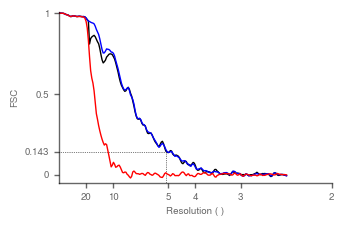

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Nimbus Sans'
import numpy as np
import scipy.optimize
import scipy.stats
import scipy as sp
import sys

shell = []
resolution = []
FSC_corrected = []
FSC_unmasked = []
FSC_masked = []
FSC_phaserand = []


star_file = "xe30kv_reconstructions_noB/reconstruct_60S-all_postprocessed.star" #5.0 A


final_res = 5.098

start = False
with open(star_file, 'r') as f:
    for line in f.readlines():
        line2 = line.strip()
        l=line2.split()
        if start == True:
            shell.append(float(l[0]))
            resolution.append(float(l[1]))
            FSC_corrected.append(float(l[3]))
            FSC_unmasked.append(float(l[5]))
            FSC_masked.append(float(l[6]))
            FSC_phaserand.append(float(l[7]))
            if (float(l[0]) >= 200.0):
                start = False
        if len(l) > 1:
            if l[0] == "_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps":
                start = True

GS_FSC = 0.143
mm = 1/25.4
fig, ax = plt.subplots(figsize=(90*mm, 60*mm))
#plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9, left=0.1)
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
for axis in ['left', 'bottom']:
    ax.spines[axis].set_linewidth(1)
    ax.spines[axis].set_color([0,0,0,0.6])
    
ax.set_ylim(bottom=-0.05, top=1.01)
ax.set_xlim(left=0, right=0.5)
ax.set_xticks([1/20, 1/10, 1/5, 1/4, 1/3, 1/2])
ax.set_xticklabels(['20', '10', '5', '4', '3', '2'])
ax.set_yticks([0, GS_FSC, 0.5, 1])
ax.set_yticklabels(['0', str(GS_FSC), '0.5', '1'])
ax.tick_params(axis='both', which='major', labelsize=7, color=[0,0,0,0.6], width=1)
ax.tick_params(axis='both', which='minor', labelsize=7, color=[0,0,0,0.6], width=1)
plt.xticks(alpha=0.6)
plt.yticks(alpha=0.6)
plt.ylabel("FSC", fontsize=7.0, alpha=0.6)
plt.xlabel("Resolution (" + u"\u212B" + ')' , fontsize=7.0, alpha=0.6)


plt.plot([0,1/final_res],[GS_FSC,GS_FSC],':',color = 'black', linewidth =0.5)
plt.plot([1/final_res,1/final_res],[-0.07,GS_FSC],':',color = 'black', linewidth =0.5)

plt.plot(resolution, FSC_corrected, '-', color = 'k', linewidth = 1)
plt.plot(resolution, FSC_masked, '-', color = 'b', linewidth = 1)
plt.plot(resolution,FSC_phaserand, '-', color = 'r', linewidth = 1)


plt.tight_layout()
plt.savefig('xe30kv_reconstructions_2/FSC_plot_all.pdf')
plt.show()

